In [1]:
# Reddit data analysis task starter.
import html
import json
import string
import re
import nltk
import praw
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# First collect the data in json-file (follow reddit_collect_data.ipynb); specify file name here
fjson = 'raw_post_comment_data.json'

In [3]:
# read json file with collected posts and comments
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)

50

In [4]:
# data record example
data[0]

{'id': 's4zw6m',
 'title': 'Unionizing your store: A how to guide',
 'text': "Hey everyone! \n\nI’ve been on this subreddit for a while and it seems like every day now we’re getting 3 types of posts. 1) New store unionizing!! 2) Peeps asking about unionizing and how to begin. Or 3) comments on horror stories telling the op to unionize.\n\nI’m an organizer at one of the newer stores to have filed to unionize, and I want to share with you the very broad strokes of how we got the ball rolling. The whole idea seemed so nebulous and scary at first, but once you have your partners on board, it’s actually surprisingly easy to start. I hope that sharing my experience will make the whole thing less intimidating.\n\nAlso: you may have your opinions on whether or not Unionizing is right for you. This post isn’t really about that conversation. This is just to help people who DO want to unionize figure out where to start. Please be nice.\n\n**Step one: Reach out.**\n\nNo seriously. If you are even 

In [5]:
# create pandas dataframe from post titles
# https://stackoverflow.com/a/43175477
df_posts = pd.DataFrame([p['title'] for p in data], columns=['title'])
df_posts

,title
0,Unionizing your store: A how to guide
1,Not being able to batch blend frappuccinos
2,To the woman who ordered a white chocolate moc...
3,made me lol
4,Yes… We confirmed her drink at least 5 times
5,I walked out today!
6,do you charge for alternative milks in shaken ...
7,Mildly infuriating
8,aw hell nah these orders be getting too compli...
9,charging for water?


In [6]:
# add columns from other data fields: combine comment and sub-comment text
df_posts['post_id'] = [p['id'] for p in data]
df_posts['text'] = [p['text'] for p in data]
df_posts['comments_lev1'] = [' '.join(p['comments_lev1']) for p in data]
df_posts['comments_lev2'] = [' '.join(p['comments_lev2']) for p in data]
df_posts

,title,post_id,text,comments_lev1,comments_lev2
0,Unionizing your store: A how to guide,s4zw6m,Hey everyone! \n\nI’ve been on this subreddit ...,As a customer I would love a company wide unio...,"If you have a union store near you, go to that..."
1,Not being able to batch blend frappuccinos,wcriib,,Micromanaging happening there!,
2,To the woman who ordered a white chocolate moc...,wc90sk,I will never forget you or what you’ve done to...,"lmaooooo what a savage, she's gonna save them ...",Another dog made it to the water. 😌 No! She wa...
3,made me lol,wccrrb,,That’s called a venti.\n*loads Caramel Glock-i...,"From what I've heard, frapp is fine, frappé so..."
4,Yes… We confirmed her drink at least 5 times,wcauvf,,Maybe that’s the strawberry ass-y that I keep ...,"I wouldn't try that, but I'm absolutely making..."
5,I walked out today!,wc3ah1,I left halfway through my shift. I left my key...,Congrats dude! I totally understand the feelin...,Ha. Yeah same. Just don’t have the heart to ju...
6,do you charge for alternative milks in shaken ...,wcr7fh,so I charge for alternative milks but it seems...,"Yes, charge. Go into the app an order one and ...","If it helps to visualize, 4oz would be half a ..."
7,Mildly infuriating,wchqgw,,"“160 degrees, no whip, foam” it feels like man...",Just cus it already is made with 2% and two sh...
8,aw hell nah these orders be getting too compli...,wbx943,,"Really, that alpha particle lady again? Sheesh...","""Ummm, I actually asked for my alpha particles..."
9,charging for water?,wcb4vn,i was just told by management today that i nee...,How do they expect you to charge for h2o? You ...,oh okay this makes sense :/ i’m in a licensed ...


In [41]:
# text cleaning function: see prior class modules
stop_words = nltk.corpus.stopwords.words('english')
new_stop_words = ['hey','everyone','ive','subreddit','every','day','getting','new','unionizing','peeps',
                  'asking','begin','horror','op','stories','telling','unionize','im','organizer','one',
                  'broad','newer','filed','want','share','broad','strokes','got','whole','idea','seemed',
                  'nebulous','scary','first','board','actually','suprisingly','easy','start','hope',
                  'sharing','experience','make','think','less','intimidating','may','whether','right','post',
                  'isnt','really','conversation','figure','step','reach','seriously','even','thinking',
                  'wanting','theyre','twitter','sbworkersunited','advice','stage','likely','theres','thats',
                  'already','organizing','put','contact','spoken','four','past','couple','RIP','cats','tiktok','why',
                  'meme','bojack','dumping','fuck','advice','gon','na','kno','cuz','trenta','rant','sensitive',
                  'documentation','pregnancy','honest','mistake','shit','love','u','time','know','partner','get','much',
                  'someone','need','thing','lol','still','looks','like','union','dues','dress','code','end','keg',
                  'pronoun','pins','mental','health','us','sm','charge','wear','shoes','go','home','never','ball']

stop_words.extend(new_stop_words)

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [42]:
# add clean text column with combined comments of both levels
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_posts['text_clean'] = (df_posts['text'] + df_posts['comments_lev1'] + df_posts['comments_lev2']).apply(text_cleanup)
df_posts

,title,post_id,text,comments_lev1,comments_lev2,text_clean
0,Unionizing your store: A how to guide,s4zw6m,Hey everyone! \n\nI’ve been on this subreddit ...,As a customer I would love a company wide unio...,"If you have a union store near you, go to that...",seems 3 types posts 1 store 2 3 comments store...
1,Not being able to batch blend frappuccinos,wcriib,,Micromanaging happening there!,,micromanaging happening
2,To the woman who ordered a white chocolate moc...,wc90sk,I will never forget you or what you’ve done to...,"lmaooooo what a savage, she's gonna save them ...",Another dog made it to the water. 😌 No! She wa...,forget youve done eyeslmaooooo savage save dam...
3,made me lol,wccrrb,,That’s called a venti.\n*loads Caramel Glock-i...,"From what I've heard, frapp is fine, frappé so...",called venti loads caramel literally dont care...
4,Yes… We confirmed her drink at least 5 times,wcauvf,,Maybe that’s the strawberry ass-y that I keep ...,"I wouldn't try that, but I'm absolutely making...",maybe strawberry keep hearing guy ask could pi...
5,I walked out today!,wc3ah1,I left halfway through my shift. I left my key...,Congrats dude! I totally understand the feelin...,Ha. Yeah same. Just don’t have the heart to ju...,left halfway shift left keys walked suffered p...
6,do you charge for alternative milks in shaken ...,wcr7fh,so I charge for alternative milks but it seems...,"Yes, charge. Go into the app an order one and ...","If it helps to visualize, 4oz would be half a ...",alternative milks seems else asked asm youre s...
7,Mildly infuriating,wchqgw,,"“160 degrees, no whip, foam” it feels like man...",Just cus it already is made with 2% and two sh...,160 degrees whip foam feels mansplaining gosh ...
8,aw hell nah these orders be getting too compli...,wbx943,,"Really, that alpha particle lady again? Sheesh...","""Ummm, I actually asked for my alpha particles...",alpha particle lady sheesh quadratic formula f...
9,charging for water?,wcb4vn,i was just told by management today that i nee...,How do they expect you to charge for h2o? You ...,oh okay this makes sense :/ i’m in a licensed ...,told management today needed charging people w...


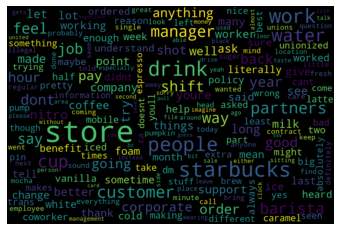

In [43]:
# most common keywords
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
text_combined = ' '.join(df_posts['text_clean'])
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(text_combined)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

In [44]:
# extract keyword counts
# https://stackoverflow.com/questions/60234036/python-word-count-from-wordcloud
kwords = WordCloud().process_text(text_combined)
kwords

{'types': 1,
 'posts': 1,
 'store': 175,
 'rolling': 3,
 'partners': 42,
 'surprisingly': 1,
 'help': 19,
 'people': 57,
 'please': 10,
 'nice': 15,
 'starbucks': 65,
 'email': 5,
 'close': 6,
 'helped': 2,
 'answer': 5,
 'swu': 3,
 'materials': 2,
 'useful': 2,
 'tools': 2,
 'stuff': 14,
 'talking': 5,
 'fence': 2,
 'corporate': 30,
 'using': 2,
 'bust': 1,
 'unions': 12,
 'lot': 23,
 'helpful': 4,
 'empowering': 1,
 'information': 13,
 'willing': 3,
 'give': 21,
 'two': 18,
 'talk': 10,
 'important': 5,
 'rest': 8,
 'paperwork': 1,
 'point': 24,
 'band': 1,
 'together': 4,
 'negotiate': 9,
 'workplace': 5,
 'better': 24,
 'person': 10,
 'trust': 1,
 'build': 1,
 'lucky': 4,
 'basically': 7,
 'waiting': 6,
 'hand': 7,
 'card': 9,
 'realized': 2,
 'sent': 3,
 'everyones': 2,
 'different': 14,
 'aggressively': 1,
 'might': 17,
 'simply': 2,
 'see': 25,
 'situation': 3,
 'recommend': 7,
 'least': 16,
 'organize': 3,
 'shared': 2,
 'group': 1,
 'text': 3,
 'message': 3,
 'discussed': 1,
 

In [45]:
# transform that dictionary into a pandas DataFrame
df_kwords = pd.DataFrame(list(kwords.items()), columns=['keyword', 'count']).set_index('keyword')
df_kwords

,count
keyword,
types,1
posts,1
store,175
rolling,3
partners,42
...,...
quality control,2
name tag,2
toffee nut,3


<AxesSubplot:xlabel='keyword'>

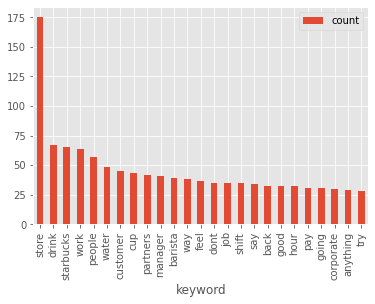

In [46]:
# plot a bar chart with the top keywords
%matplotlib inline
df_kwords.sort_values(by='count', ascending=False).head(25).plot.bar()

In [35]:
# NLTK collocations search (words occuring together): bigrams
# https://www.nltk.org/howto/collocations.html
# http://www.nltk.org/api/nltk.html#nltk.util.bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigram_finder = BigramCollocationFinder.from_documents([d.split() for d in df_posts['text_clean']])

In [36]:
# filter out bigrams occurring less than three times in the combined text
bigram_finder.apply_freq_filter(3)

In [37]:
# list of bigrams with their frequencies
bigram_freq = list(bigram_finder.ngram_fd.items())
bigram_freq

[(('ball', 'rolling'), 3),
 (('starbucks', 'workers'), 6),
 (('workers', 'united'), 9),
 (('store', 'basically'), 3),
 (('many', 'people'), 6),
 (('group', 'chat'), 4),
 (('store', 'manager'), 5),
 (('big', 'deal'), 4),
 (('working', 'starbucks'), 4),
 (('store', 'partners'), 3),
 (('drive', 'times'), 4),
 (('unionized', 'stores'), 3),
 (('licensed', 'store'), 8),
 (('pretty', 'sure'), 3),
 (('company', 'work'), 3),
 (('starbucks', 'job'), 3),
 (('8', 'hours'), 3),
 (('years', 'ago'), 4),
 (('would', 'change'), 3),
 (('good', 'luck'), 3),
 (('valid', 'reason'), 3),
 (('help', 'stores'), 3),
 (('stores', 'area'), 3),
 (('would', 'say'), 3),
 (('entry', 'level'), 3),
 (('would', 'ask'), 3),
 (('cant', 'imagine'), 3),
 (('baristas', 'shifts'), 3),
 (('voted', 'members'), 3),
 (('6', 'months'), 3),
 (('year', 'half'), 3),
 (('water', 'cup'), 4),
 (('never', 'seen'), 3),
 (('white', 'mocha'), 7),
 (('cold', 'brew'), 13),
 (('never', 'let'), 3),
 (('2', 'weeks'), 3),
 (('siren', 'win'), 3),


In [38]:
# collect into a pandas dataframe
df_freq = pd.DataFrame([(' '.join(k), v) for k,v in bigram_freq], columns=['keyphrase', 'count'])
df_freq.sort_values(by='count', ascending=False, inplace=True)
df_freq.set_index('keyphrase', inplace = True)
df_freq

,count
keyphrase,
cold brew,13
workers united,9
licensed store,8
white mocha,7
many people,6
...,...
never seen,3
never let,3
siren win,3


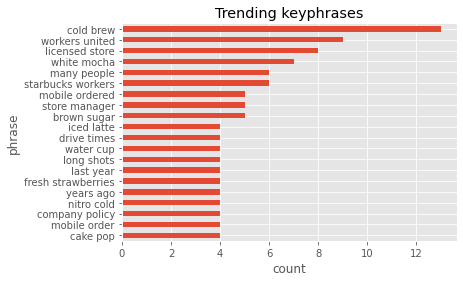

In [39]:
plt.style.use('ggplot')

# render a horizontal bar graph
df_freq.head(20).sort_values(by='count').plot(kind = 'barh')
plt.title('Trending keyphrases')
plt.ylabel('phrase')
plt.xlabel('count')
plt.legend().set_visible(False)
plt.show()